## Code to find intersections of ICESat-2 and ATM data

**by Allison Chartrand**

**June 2019 ICESat-2 Hackweek**


In [1]:
#IMPORT PACKAGES
import os
import glob
import pandas as pd
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import pyproj
from scipy.spatial import distance

Code to extract single tracks of IceSat-2 data

In [2]:
ATL06data = pd.read_csv('../extractData/IceSat2ZachData')

In [3]:
ATL06data['track'].unique()

array(['gt3r', 'gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l'], dtype=object)

In [4]:
ATL06data.date.unique()

array(['2019-01-04 12:24:25', '2019-02-15 10:09:55',
       '2018-10-29 05:05:08', '2019-01-16 01:09:49',
       '2018-11-23 03:49:31', '2018-12-10 02:50:30',
       '2018-12-19 12:57:40', '2019-01-08 01:26:37',
       '2018-11-20 14:21:44', '2018-12-26 02:17:13',
       '2019-02-17 23:37:46', '2018-11-16 14:30:09',
       '2018-11-27 03:41:06', '2018-12-27 12:41:01',
       '2018-10-21 05:21:45', '2018-12-23 12:49:22',
       '2018-10-22 15:45:34', '2018-12-14 02:42:09',
       '2018-12-15 13:05:59', '2019-01-20 01:01:33',
       '2018-12-18 02:33:52', '2019-01-13 11:42:01',
       '2019-01-29 11:08:55', '2018-11-15 04:06:22',
       '2018-11-19 03:57:57', '2018-12-02 13:56:37',
       '2018-10-17 05:30:05', '2019-01-17 11:33:37',
       '2018-10-25 05:13:27', '2018-10-30 15:28:58',
       '2019-01-21 11:25:25', '2019-02-13 23:46:06',
       '2018-10-26 15:37:16', '2019-01-28 00:45:05',
       '2019-01-12 01:18:14', '2018-12-30 02:08:55',
       '2019-01-25 11:17:11', '2018-12-31 12:3

Define dataframe for output

In [5]:
Intersections = {'dist_along':[],'ATM_elev':[],'idx_ATM':[],'z_ATL06':[],'t_ATL06':[],'idx_ATL06':[],'gt_ATL06':[]}
Intersections = pd.DataFrame(data = Intersections)

print(Intersections.head())
ATL06data.head()

Empty DataFrame
Columns: [dist_along, ATM_elev, idx_ATM, z_ATL06, t_ATL06, idx_ATL06, gt_ATL06]
Index: []


,lon,lat,h,track,date,x,y
0,-22.520585,78.700068,579.33765,gt3r,2019-01-04 12:24:25,469494.782922,-1.134613e+06
1,-22.520755,78.700244,579.03015,gt3r,2019-01-04 12:24:25,469484.057930,-1.134597e+06
2,-22.520925,78.700420,578.78815,gt3r,2019-01-04 12:24:25,469473.331404,-1.134581e+06
3,-22.521094,78.700596,578.57214,gt3r,2019-01-04 12:24:25,469462.614457,-1.134564e+06
4,-22.521264,78.700773,578.33830,gt3r,2019-01-04 12:24:25,469451.884907,-1.134548e+06


Define nearest neighbor algorithm

In [6]:
def closest_node(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    closest_dist = np.min(distance.cdist([node], nodes,'euclidean'))
    return closest_index, closest_dist

Get target points from ATM csv and put into dataframe

In [7]:
ATMdata = pd.read_csv('~/xtrak/data/ATMprof_20190418.csv')

tpoints = ATMdata[['PS_x','PS_y']].copy()
tpoints = tpoints.values
ATMdata.head()

,ATM_lat,ATM_long,PS_x,PS_y,ATM_elev,dist_along
0,79.212155,334.848567,397916.203061,-1.102322e+06,891.6397,0.000000
1,79.212039,334.850146,397950.884957,-1.102323e+06,891.4861,34.695014
2,79.211923,334.851724,397985.547970,-1.102324e+06,891.3228,69.371314
3,79.211808,334.853304,398020.212712,-1.102325e+06,891.1725,104.046285
4,79.211692,334.854884,398054.914911,-1.102326e+06,891.0138,138.761317


Make an empty dataframe for intersections
Get query points from ATL06 csv and put into dataframe
Loop through unique dates and ground tracks and find the closest point between each ground track and the flowline
Store intersection along-flow distance, z_ATM, z_ATL06 and other helpful data in Intersections dataframe

In [8]:
Intersections = {'dist_along':[],'ATM_elev':[],'idx_ATM':[],'z_ATL06':[],'t_ATL06':[],'idx_ATL06':[],'gt_ATL06':[]}
Intersections = pd.DataFrame(data = Intersections)
i = 0
for day in ATL06data.date.unique():

    for tr in ATL06data.track.unique():
        close_idx = []
        min_dist = []
        AddDatarow = []

        #dfTran is a single radar transect
        dfTran = ATL06data.query('date == @day & track == @tr')
        if dfTran.shape[0] == 0:
            continue
            
        
        qpoints = dfTran[['x','y']].copy()
        qpoints = qpoints.values

        
        for j in range(len(tpoints)):
            close_idxT,min_distT = closest_node(tpoints[j,:], qpoints)
            close_idx = np.append(close_idx,[close_idxT])
            min_dist = np.append(min_dist,[min_distT])
        if min(min_dist) > 1000:
            continue
        
        tpt_idx = np.argmin(min_dist)
        qpt_idx = int(close_idx[tpt_idx])
        dfTran_idx = dfTran.loc[dfTran['date'] == day].index[0]
        qpt_idx = qpt_idx+dfTran_idx
        
        AddDatarow = {'dist_along':[ATMdata.loc[tpt_idx,'dist_along']],
                      'ATM_elev':[ATMdata.loc[tpt_idx,'ATM_elev']],
                      'idx_ATM':[tpt_idx],
                      'z_ATL06':[dfTran.loc[qpt_idx,'h']],
                      't_ATL06':[dfTran.loc[qpt_idx,'date']],
                      'idx_ATL06':[qpt_idx],
                      'gt_ATL06':[dfTran.loc[qpt_idx,'track']]}
        AddDatarow = pd.DataFrame(data = AddDatarow)
        Intersections = Intersections.append(AddDatarow)
        

In [9]:
print(Intersections)


       dist_along  ATM_elev  idx_ATM     z_ATL06              t_ATL06  \
0   125293.549537   36.6189   3399.0   35.714657  2019-02-15 10:09:55   
0   125388.182985   35.0684   3402.0   34.106010  2019-02-15 10:09:55   
0    96217.510032   88.3644   2580.0   66.844490  2019-01-16 01:09:49   
0   102715.054408   30.4860   2761.0   29.333950  2019-01-16 01:09:49   
0   102652.754159   33.3447   2759.0   38.831944  2019-01-16 01:09:49   
0    99520.169480   30.0488   2662.0   74.656880  2019-01-16 01:09:49   
0    99425.209764   29.2814   2659.0   74.915375  2019-01-16 01:09:49   
0    96311.339018   91.5448   2583.0   69.498950  2019-01-16 01:09:49   
0    66750.738279  431.6262   1748.0  429.581600  2018-11-23 03:49:31   
0    73145.188827  248.8764   1939.0  246.065860  2018-11-23 03:49:31   
0    73077.151360  249.9702   1937.0  247.515430  2018-11-23 03:49:31   
0    69947.598270  318.5833   1844.0  307.515300  2018-11-23 03:49:31   
0    69881.896892  319.3689   1842.0  309.190640  2

In [10]:

Intersections.to_csv('~/xtrak/extractData/Intersections_ATM20180418.csv',index=False)

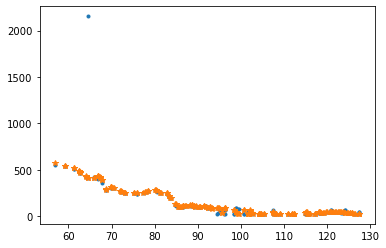

In [14]:
fig = plt.figure
plt.plot(Intersections['dist_along']/1000,Intersections['z_ATL06'],'.')
plt.plot(Intersections['dist_along']/1000,Intersections['ATM_elev'],'*')
